In [1]:
# https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
import matplotlib.pyplot as plt

In [2]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
#     -O /datasets/bbc-text.csv

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

In [5]:
articles = []
labels = []

with open("./datasets/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [6]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [7]:
print("train_size", train_size)

print(f"train_articles {len(train_articles)}")

print("train_labels", len(train_labels))

print("validation_articles", len(validation_articles))

print("validation_labels", len(validation_labels))

train_size 1780
train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [9]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 4s - loss: 1.5724 - accuracy: 0.3079 - val_loss: 1.3411 - val_accuracy: 0.4045 - 4s/epoch - 78ms/step
Epoch 2/10
56/56 - 3s - loss: 1.0921 - accuracy: 0.5860 - val_loss: 0.7909 - val_accuracy: 0.7326 - 3s/epoch - 45ms/step
Epoch 3/10
56/56 - 2s - loss: 0.7339 - accuracy: 0.7579 - val_loss: 0.6100 - val_accuracy: 0.7685 - 2s/epoch - 44ms/step
Epoch 4/10
56/56 - 2s - loss: 0.3676 - accuracy: 0.8910 - val_loss: 0.4519 - val_accuracy: 0.8854 - 2s/epoch - 44ms/step
Epoch 5/10
56/56 - 2s - loss: 0.3270 - accuracy: 0.8921 - val_loss: 0.4236 - val_accuracy: 0.8876 - 2s/epoch - 43ms/step
Epoch 6/10
56/56 - 2s - loss: 0.1590 - accuracy: 0.9511 - val_loss: 0.3083 - val_accuracy: 0.9056 - 2s/epoch - 44ms/step
Epoch 7/10
56/56 - 2s - loss: 0.0874 - accuracy: 0.9803 - val_loss: 0.2263 - val_accuracy: 0.9303 - 2s/epoch - 44ms/step
Epoch 8/10
56/56 - 2s - loss: 0.1010 - accuracy: 0.9787 - val_loss: 0.2187 - val_accuracy: 0.9303 - 2s/epoch - 44ms/step
Epoch 9/10
56/56 - 2s - loss: 0.

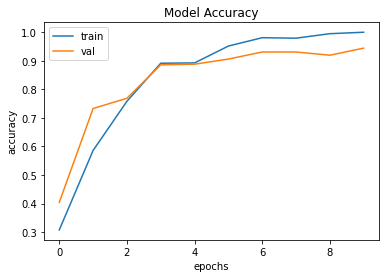

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("./img/textclassacc.png", format="png")

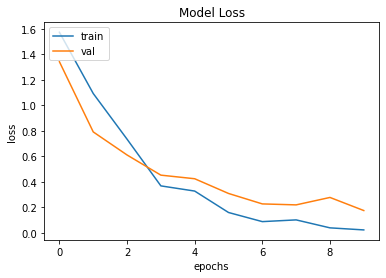

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("./img/textclassloss.png", format="png")

In [15]:
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 0s 315ms/step
[[8.5645799e-05 1.0570924e-03 1.2145102e-04 9.9487126e-01 2.3318108e-03
  1.5328124e-03]]
3
politics


In [16]:
txt = ["call to save manufacturing jobs the trades union congress (tuc) is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies.  the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year. it calls for better pensions  child care provision and decent wages. the 36-page submission also urges the government to examine support other european countries provide to industry. tuc general secretary brendan barber called for  a commitment to policies that will make a real difference to the lives of working people.    greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents   he said.  a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs.  he also called for  practical measures  to help pensioners  especially women who he said  are most likely to retire in poverty . the submission also calls for decent wages and training for people working in the manufacturing sector."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 0s 15ms/step
[[1.9029436e-03 3.4469427e-04 9.3412781e-01 5.1404769e-03 4.9247086e-02
  9.2368955e-03]]
2
bussiness
